<a href="https://colab.research.google.com/github/mohan844/Food_101_CNN/blob/main/Project_CNN_food_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 07 Milestone Project: 🍔👁 Food Vision Big™
We're going to be building Food Vision Big™, using all of the data from the Food101 dataset.

Yep. All 75,750 training images and 25,250 testing images.

And guess what...

**we've got the goal of beating [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment)**, a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.

## What we're going to cover

* Using TensorFlow Datasets to download and explore data
* Creating preprocessing function for our data
* Batching & preparing datasets for modelling (**making our datasets run fast**)
* Creating modelling callbacks
* Setting up **mixed precision training**
* Building a feature extraction model.
* Fine-tuning the feature extraction model.
* Viewing training results on TensorBoard.
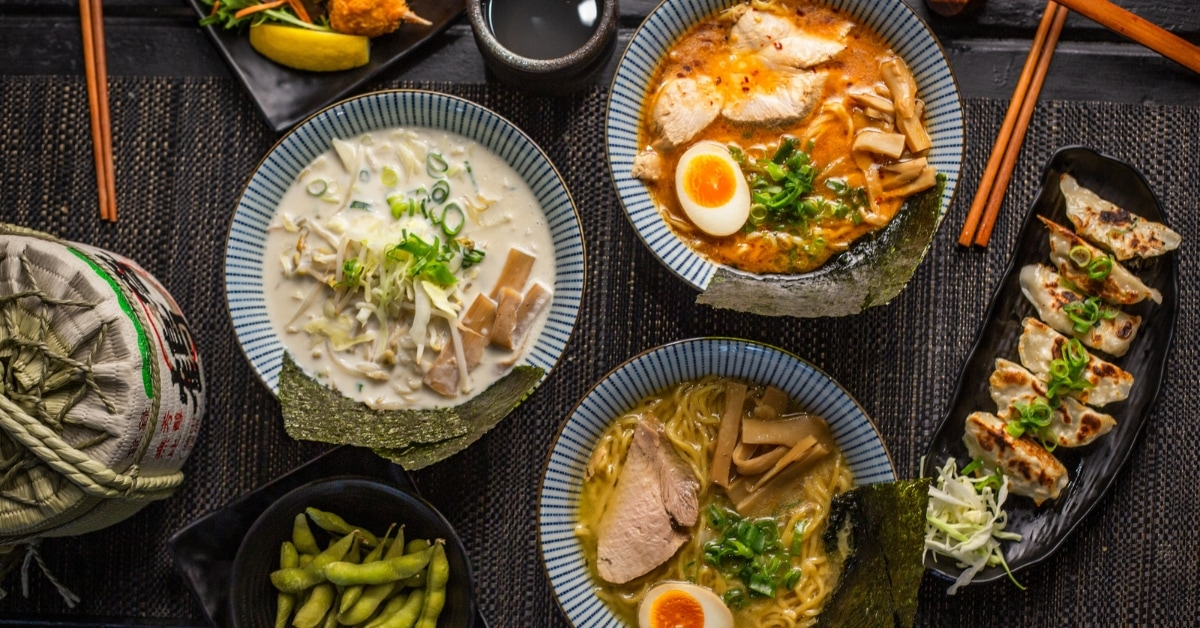

In [ ]:
# Connecting g-drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Check GPU

For this notebook

We're going to be using mixed precision training.


What does **mixed precision training** do?

Mixed precision training uses a combination of single precision (float32) and half-preicison (float16) data types to speed up model training (up 3x on modern GPUs).


For now, before we can move forward if we want to use mixed precision training, we need to make sure the GPU powering our Google Colab instance (if you're using Google Colab) is compataible.

For mixed precision training to work, **you need access to a GPU with a compute compability score of 7.0+**.

Google Colab offers several kinds of GPU.

However, some of them **aren't compatiable with mixed precision training.**

Therefore to make sure you have access to mixed precision training in Google Colab, you can check your GPU compute capability score on [Nvidia's developer website](https://developer.nvidia.com/cuda-gpus#compute).

As of May 2023, the GPUs available on Google Colab which allow mixed precision training are:
* NVIDIA A100 (available with Google Colab Pro)
* NVIDIA Tesla T4


In [ ]:
# Check the GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-861b8a4d-4a95-a989-0f97-b3de9a4d3a9a)


**Congrats we have the access of Nvidia Tesla T4 we can use mixed precision**

## Get helper functions

We've created a series of helper functions throughout the previous notebooks in the course. Instead of rewriting them (tedious), we'll import the [`helper_functions.py`](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py) file from the GitHub repo.

In [10]:
# Import the Helper functions:
!wget https://raw.githubusercontent.com/mohan844/Food_101_CNN/main/helper_functions_1.py

--2023-12-25 15:34:23--  https://raw.githubusercontent.com/mohan844/Food_101_CNN/main/helper_functions_1.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions_1.py’

helper_functions_1. 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-25 15:34:23 (94.5 MB/s) - ‘helper_functions_1.py’ saved [10246/10246]



In [11]:
# Import some functions from helper functions:
from helper_functions_1 import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data
For this Note book we are going to use Tensorflow Dataset.

For many of the most popular datasets in the machine learning world (often referred to and used as benchmarks), you can access them through [TensorFlow Datasets (TFDS)](https://www.tensorflow.org/datasets/overview).

What is **TensorFlow Datasets**?

A place for prepared and ready-to-use machine learning datasets.

Why use TensorFlow Datasets?

* Load data already in Tensors
* Practice on well established datasets
* Experiment with differet data loading techniques (like we're going to use in this notebook)
* Experiment with new TensorFlow features quickly (such as mixed precision training)

Why *not* use TensorFlow Datasets?

* The datasets are static (they don't change, like your real-world datasets would)
* Might not be suited for your particular problem (but great for experimenting)

To begin using TensorFlow Datasets we can import it under the alias `tfds`.

In [56]:
# Get TensorFlow Dataset:
import tensorflow as tf
import tensorflow_datasets as tfds

# Get all the dataset in list format:
dataset_list = tfds.list_builders()

# Check food 101 is in our list ?
print(f'Food 101 is in our data set:{"food101"in dataset_list}')

Food 101 is in our data set:True


In [57]:
# Download the dataset and split into train and validation:
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=["train","validation"],
                                             shuffle_files=False, # Keep the shuffle off at this time, we will do it later while building piplines.
                                             as_supervised=True,
                                             with_info = True)

## Exploring the Food101 data from TensorFlow Datasets

Now we've downloaded the Food101 dataset from TensorFlow Datasets, how about we do what any good data explorer should?

In other words, "visualize, visualize, visualize".

Let's find out a few details about our dataset:
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
* Do the labels match up with the class names?

To do, let's take one sample off the training data (using the [`.take()` method](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take)) and explore it.

In [14]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [15]:
# make a list for all class names:
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [16]:
# Check the lengths of train and Test data:
len(train_data), len(test_data)

(75750, 25250)

we will get same image every time, because we used the `as_supervised=False` parameter in our `tfds.load()` method above, data samples come in the tuple format structure `(data, label)` or in our case `(image_tensor, label)`.

In [17]:
# Take one example from the train data:
take_one = train_data.take(1)

# Iterate over the image:
for image,label in take_one:
  print("Shape:",image.shape)
  print("Data Type:",image.dtype)
  print("Label name:",class_names[label.numpy()])


Shape: (512, 512, 3)
Data Type: <dtype: 'uint8'>
Label name: huevos_rancheros


In [18]:
# Check the how image Tensor looks like:
print(f"Image Tensor before processing:{image[:5,:5,:]}\n Shape:{image.shape} and having Data Type: {image.dtype} ")

Image Tensor before processing:[[[233 253 251]
  [231 253 250]
  [228 254 251]
  [224 255 251]
  [218 255 252]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  [222 255 253]
  [217 255 252]]

 [[228 254 253]
  [226 255 253]
  [223 255 252]
  [218 255 254]
  [212 255 254]]

 [[223 255 254]
  [220 254 253]
  [217 255 253]
  [214 255 254]
  [207 255 253]]

 [[216 255 254]
  [214 254 253]
  [210 255 252]
  [206 255 252]
  [203 254 255]]]
 Shape:(512, 512, 3) and having Data Type: <dtype: 'uint8'> 


In [19]:
# Checking the min and max pixel value:
tf.reduce_max(image),tf.reduce_min(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=255>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=0>)

Alright looks like our image tensors have values of between 0 & 255 (standard red, green, blue colour values) and the values are of data type `unit8`.

We might have to preprocess these before passing them to a neural network. But we'll handle this later.

In the meantime, let's see if we can plot an image sample.

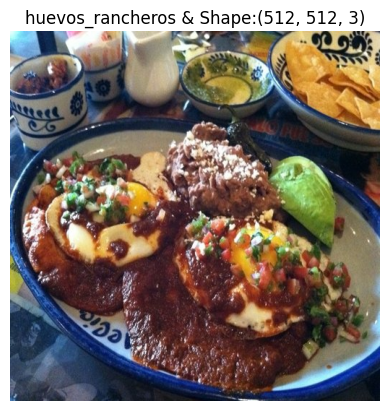

In [20]:
# Plot the image:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(f"{class_names[label.numpy()]} & Shape:{image.shape}")
plt.axis(False);

## Create preprocessing functions for our data

 Since we've downloaded the data from TensorFlow Datasets, there are a couple of preprocessing steps we have to take before it's ready to model.

More specifically, our data is currently:

* In `uint8` data type
* Comprised of all differnet sized tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

Whereas, models like data to be:

* In `float32` data type
* Have all of the same size tensors (batches require all tensors have the same shape, e.g. `(224, 224, 3)`)
* Scaled (values between 0 & 1), also called normalized

To take care of these, we'll create a `pre_process_image()` function.

> 🔑 **Note:** Pretrained EfficientNetBX models in [`tf.keras.applications.efficientnet`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet) (what we're going to be using) have rescaling built-in. But for many other model architectures you'll want to rescale your data (e.g. get its values between 0 & 1). This could be incorporated inside your "`pre_process_image()`" function (like the one below) or within your model as a [`tf.keras.layers.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) layer.

In [21]:
# Create a Function to change the data type and scale the image in proper format:

def pre_process_image(image,label,shape=224):
  image = tf.image.resize(image,[shape,shape])
  image = tf.cast(image,tf.float32)
  return image,label

In [22]:
# Applying the function to process the image:
image_final,label = pre_process_image(image,label)

# Check how our new Tensor looks like:
print(f"Image Tensor after processing:{image_final[:5,:5,:]}\n Shape:{image_final.shape} and having Data Type: {image_final.dtype} ")

Image Tensor after processing:[[[230.65816 253.64285 251.     ]
  [222.99998 254.97449 252.19388]
  [207.06633 255.      250.36734]
  [186.92857 254.35715 249.17857]
  [168.07652 252.0153  251.7245 ]]

 [[221.47449 254.37755 253.33163]
  [214.5102  255.      253.92348]
  [198.41327 254.58673 251.96939]
  [178.7857  251.10715 252.39285]
  [163.18367 248.77042 254.80103]]

 [[204.21428 253.42857 249.57143]
  [198.71428 254.64287 251.2449 ]
  [185.04591 251.73979 252.21428]
  [167.42857 248.67857 253.78572]
  [144.47958 235.88264 246.62244]]

 [[187.67857 252.64285 245.32143]
  [187.07143 254.5     250.92857]
  [175.32143 254.17857 253.10715]
  [159.      247.      252.25   ]
  [143.      238.4643  251.39285]]

 [[165.65814 243.64795 238.21938]
  [169.5051  250.70409 248.00511]
  [164.86224 252.35715 253.85205]
  [153.60715 244.60715 253.17857]
  [140.31122 235.7143  251.02551]]]
 Shape:(224, 224, 3) and having Data Type: <dtype: 'float32'> 


Cool... Done Digits tuns to Float and shape turn to (224,224,3).
Now Lets Visualize the image again ..

(-0.5, 223.5, 223.5, -0.5)

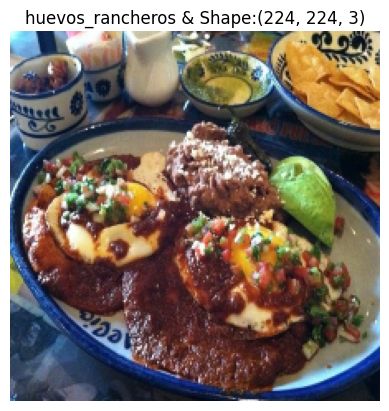

In [23]:
# Plot the image:
import matplotlib.pyplot as plt
plt.imshow(image_final/255.)
plt.title(f"{class_names[label.numpy()]} & Shape:{image_final.shape}")
plt.axis(False)

## Batch & prepare datasets

Before we can model our data, we have to turn it into batches.

Why?

Because computing on batches is memory efficient.

We turn our data from 101,000 image tensors and labels (train and test combined) into batches of 32 image and label pairs, thus enabling it to fit into the memory of our GPU.

To do this in effective way, we're going to be leveraging a number of methods from the [`tf.data` API](https://www.tensorflow.org/api_docs/python/tf/data).

Specifically, we're going to be using:

* [`map()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) - maps a predefined function to a target dataset (e.g. `preprocess_img()` to our image tensors)
* [`shuffle()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) - randomly shuffles the elements of a target dataset up `buffer_size` (ideally, the `buffer_size` is equal to the size of the dataset, however, this may have implications on memory)
* [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) - turns elements of a target dataset into batches (size defined by parameter `batch_size`)
* [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but costs memory)
* Extra: [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) - caches (saves them for later) elements in a target dataset, saving loading time (will only work if your dataset is small enough to fit in memory, standard Colab instances only have 12GB of memory)

Things to note:
- Can't batch tensors of different shapes (e.g. different image sizes, need to reshape images first, hence our `preprocess_img()` function)
- `shuffle()` keeps a buffer of the number you pass it images shuffled, ideally this number would be all of the samples in your training set, however, if your training set is large, this buffer might not fit in memory (a fairly large number like 1000 or 10000 is usually suffice for shuffling)
- For methods with the `num_parallel_calls` parameter available (such as `map()`), setting it to`num_parallel_calls=tf.data.AUTOTUNE` will parallelize preprocessing and significantly improve speed
- Can't use `cache()` unless your dataset can fit in memory

Woah, the above is alot. But once we've coded below, it'll start to make sense.

We're going to through things in the following order:

```
Original dataset (e.g. train_data) -> map() -> shuffle() -> batch() -> prefetch() -> PrefetchDataset
```

Additionally , we will also use **Data Augmentation** we can apply a Sequential layer for Data Augmentation, but we are going to use it as a seprate function so before model Execution all the pre-process of data done.

The [data_augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) function applies random image transformations to enhance the diversity of the dataset for training neural networks. It includes horizontal and vertical flips, random changes in brightness, and random adjustments to image contrast. These augmentations help the model generalize better by exposing it to variations in the input data, thereby improving its robustness and performance during training.

In [24]:
# create function for Augmentation:
def data_augmentation(image,label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  image = tf.image.random_brightness(image, max_delta=0.2)
  image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
  return image,label

In [25]:
# Creating the piplines for Data Preprocessings:

# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func = pre_process_image, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.map(map_func=data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it(load it faster):
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Similarly for the test data:
test_data = test_data.map(map_func=pre_process_image,num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
# Lets check whats our data look likes:
train_data,test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks

Since we're going to be training on a large amount of data and training could take a long time, it's a good idea to set up some modelling callbacks so we be sure of things like our model's training logs being tracked and our model being checkpointed (saved) after various training milestones.

To do each of these we'll use the following callbacks:
* [`tf.keras.callbacks.TensorBoard()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) - allows us to keep track of our model's training history so we can inspect it later (**note:** we've created this callback before have imported it from `helper_functions.py` as `create_tensorboard_callback()`)
* [`tf.keras.callbacks.ModelCheckpoint()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - saves our model's progress at various intervals so we can load it and resuse it later without having to retrain it
  * Checkpointing is also helpful so we can start fine-tuning our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits

In [28]:
# Now create Model Callbacks:

# Import Tensorboard callback fom the imported helper function:
from helper_functions_1 import create_tensorboard_callback

# Create a function  Callback for saving checkpoints:
def weight_saving_chekpoint(file_name):
  checkpoint_path = 'model_checkpoint/'+ file_name + '.ckpt'
  model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                        monitor = 'val_accuracy',
                                                        save_best_only=True,
                                                        save_weights_only = True,
                                                        verbose=0)
  return model_checkpoint

## Setup mixed precision training

Mixed precision training is a technique that utilizes both 16-bit and 32-bit floating-point data types during neural network training. It is beneficial because it accelerates training by reducing memory usage and computational overhead. The model's forward and backward passes are performed in 16-bit precision, saving memory, while critical operations like weight updates use 32-bit precision to maintain numerical stability. This mixed precision approach takes advantage of the speed of lower precision for most computations while ensuring accuracy is preserved where needed, resulting in faster training times for deep learning models.

In [29]:
# Turn on Mixed precision Training:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy='mixed_float16')

In [30]:
# Lets check the policy:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Now create a feature extraction model from EfficientNetV2B0():
eature extraction with EfficientNet in TensorFlow involves two key steps: freezing initial layers and fine-tuning.

1. **Freezing Initial Layers**:
  * Concept: Utilize the knowledge captured by the pre-trained EfficientNet on a large dataset, especially in low-level feature extraction (edges, textures).
  * Implementation: Lock these initial layers to preserve pre-trained knowledge during subsequent training on a specific task.

2.  **Adding Custom Top Layers**:
  * Concept: Append task-specific layers (e.g., dense layers) on top of the frozen EfficientNet base to adapt the model to a specific classification or regression task.
  * Implementation: Customize the model's top layers according to the target task, allowing the model to learn task-specific features.

3. **Fine-Tuning by Unfreezing Layers**:
  * Concept: Gradually unfreeze and enable training for some of the initially frozen layers, allowing the model to adjust to the specifics of the target task.
  * Implementation: Unfreeze a subset of layers during training epochs, allowing the model to update these layers based on task-specific data.

4. **Optimizing Hyperparameters**:
  * Concept: Adjust learning rates, regularization, and other hyperparameters to optimize the balance between leveraging pre-trained features and learning task-specific information.
  * Implementation: Experiment with different hyperparameter configurations to enhance model performance and convergence.

By following these steps, feature extraction with EfficientNet enables the model to leverage pre-trained knowledge for efficient learning on specific tasks, striking a balance between generalization and task adaptation.

In [31]:
import tensorflow as tf
from tensorflow.keras import layers


# Create the base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)

# Freeze the base model
base_model.trainable = False

# Create the Layers:
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)  # Put training = False to run in Inference mode i.e Normalizing of layers is OFF.
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name="softmax_float32")(x)  # Keep the data of last layers should be in float32 (Mixed Precision)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",  # Keep the loss sparse_categorical_crossentropy because labels are not one hot encoded.
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

24274472/24274472 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

## Checking layer dtype policies (are we using mixed precision?)

Model ready to go!

Before we said the mixed precision API will automatically change our layers' dtype policy's to whatever the global dtype policy is (in our case it's `"mixed_float16"`).

We can check this by iterating through our model's layers and printing layer attributes such as `dtype` and `dtype_policy`.

In [ ]:
# Check the model storage data type and training data type:
for layer in model.layers:
  print(layer.name,layer.dtype,layer.dtype_policy)

input_layer float32 <Policy "float32">
efficientnetv2-b0 float32 <Policy "mixed_float16">
pooling_layer float32 <Policy "mixed_float16">
dense float32 <Policy "mixed_float16">
softmax_float32 float32 <Policy "float32">


In [ ]:
# Checking same in the base layer:
for layer in model.layers[1].layers:
  print(layer.name,layer.dtype,layer.dtype_policy)

input_1 float32 <Policy "float32">
rescaling float32 <Policy "mixed_float16">
normalization float32 <Policy "mixed_float16">
stem_conv float32 <Policy "mixed_float16">
stem_bn float32 <Policy "mixed_float16">
stem_activation float32 <Policy "mixed_float16">
block1a_project_conv float32 <Policy "mixed_float16">
block1a_project_bn float32 <Policy "mixed_float16">
block1a_project_activation float32 <Policy "mixed_float16">
block2a_expand_conv float32 <Policy "mixed_float16">
block2a_expand_bn float32 <Policy "mixed_float16">
block2a_expand_activation float32 <Policy "mixed_float16">
block2a_project_conv float32 <Policy "mixed_float16">
block2a_project_bn float32 <Policy "mixed_float16">
block2b_expand_conv float32 <Policy "mixed_float16">
block2b_expand_bn float32 <Policy "mixed_float16">
block2b_expand_activation float32 <Policy "mixed_float16">
block2b_project_conv float32 <Policy "mixed_float16">
block2b_project_bn float32 <Policy "mixed_float16">
block2b_drop float32 <Policy "mixed_fl

In [ ]:
# Fit the model:
history = model.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data = test_data,
                    validation_steps = int(0.15*(len(test_data))), # Validating  on 15 percent of Dataset
                    callbacks=[create_tensorboard_callback("training_logs","efficientnetV2B0_101_model"),weight_saving_chekpoint('model')])

Saving TensorBoard log files to: training_logs/efficientnetV2B0_101_model/20231225-115705
Epoch 1/5
2368/2368 [==============================] - 246s 96ms/step - loss: 2.1158 - accuracy: 0.4895 - val_loss: 1.2629 - val_accuracy: 0.6809
Epoch 2/5
2368/2368 [==============================] - 218s 91ms/step - loss: 1.6057 - accuracy: 0.5927 - val_loss: 1.1331 - val_accuracy: 0.6992
Epoch 3/5
2368/2368 [==============================] - 213s 89ms/step - loss: 1.4810 - accuracy: 0.6193 - val_loss: 1.0854 - val_accuracy: 0.7135
Epoch 4/5
2368/2368 [==============================] - 212s 88ms/step - loss: 1.3999 - accuracy: 0.6376 - val_loss: 1.0449 - val_accuracy: 0.7285
Epoch 5/5
2368/2368 [==============================] - 214s 89ms/step - loss: 1.3493 - accuracy: 0.6491 - val_loss: 1.0297 - val_accuracy: 0.7254


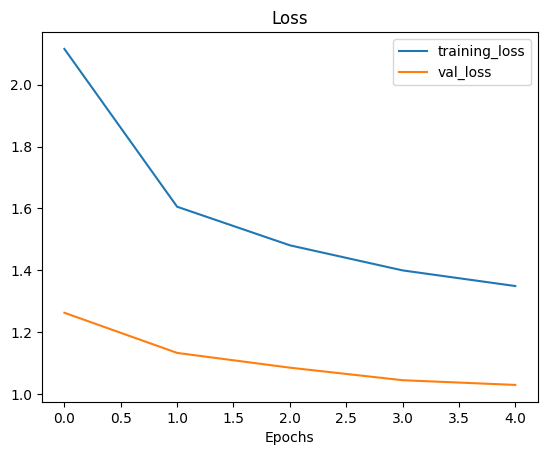

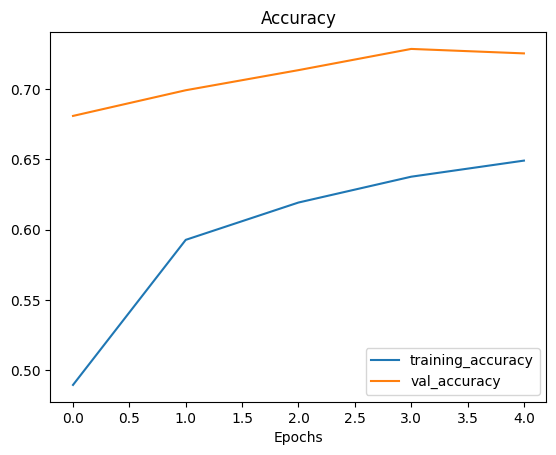

In [ ]:
# Plotting the Loss and accuracy Curve:
plot_loss_curves(history)

Model shows Good performance on Validation set than the training set. But we have note that after certain epochs validation accuracy is not increases. But however we got the accuracy of 72.54 %. Now check on full Training Dataset:

In [ ]:
# Now predict the whole test dataset:
model.evaluate(test_data)

790/790 [==============================] - 56s 70ms/step - loss: 1.0344 - accuracy: 0.7232


[1.0343741178512573, 0.7231683135032654]

Hence we have got the accuracy of 72.32% on the full Dataset. Now we are going to save this model as base model for the fine Tunning.

In [ ]:
# Save this model to local drive:
model.save('/content/drive/MyDrive/Tensorflow/CNN project/model.keras')

We have saved the best model check point now we can test that if it shows better results:

In [ ]:
# creating a function which can provide the new Scratch model:
def new_model():
  # Create the base model
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
  # Freeze the base model
  base_model.trainable = False

  inputs = layers.Input(shape=input_shape, name="input_layer")
  x = base_model(inputs, training=False)  # Put training = False to run in Inference mode
  x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
  x = layers.Dense(len(class_names))(x)
  outputs = layers.Activation('softmax', dtype=tf.float32, name="softmax_float32")(x)
  model = tf.keras.Model(inputs, outputs)

  # Compile the model
  model.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
  return model

In [ ]:
# Call the scratch model:
checkpoint_model = new_model()
# Load the best saved weights:
checkpoint_model.load_weights("/content/model_checkpoint/model.ckpt")
# Evaluate the model:
checkpoint_model.evaluate(test_data)

790/790 [==============================] - 56s 66ms/step - loss: 1.0513 - accuracy: 0.7192


[1.0512704849243164, 0.7191683053970337]

There is no huge Difference we can count on original accurracy.

Now we are going to Tune the model by Unfreezing the top 10 layers:

In [ ]:
# Now we going to fine tune the model from the base model:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

Currently efficientnetv2-b0's  5919312 are not trainable means all the layers are freezed. Now its time to unfreeze some of the layers.

In [ ]:
for layer_no, layer in enumerate(model.layers[1].layers):
  print(layer_no,layer.name,layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 Fals

In [ ]:
# Unfreeze all the layers:
base_model.trainable=True

# Now freeze the all the layers but left the last 10 layers:
for layers in base_model.layers[:-10]:
  layers.trainable = False


In [ ]:
# Compile the model again with low learning rate because we keep the learning slow so that weights are not will altered much:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics=['accuracy'])

In [ ]:
for layer_no, layer in enumerate(model.layers[1].layers):
  print(layer_no,layer.name,layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 Fals

Done last 10 layers are unfreezed...

In [ ]:
fine_tune_epochs = 10 # Model is already trained on the 5 epochs, we are going to for another 5 epochs:
history_fine_tune_model_10_layer = model.fit(train_data,
                                    epochs = fine_tune_epochs,
                                    steps_per_epoch = len(train_data),
                                    validation_data = test_data,
                                    validation_steps=int(0.15 * len(test_data)),
                                    initial_epoch = history.epoch[-1],
                                    callbacks=[create_tensorboard_callback("training_logs","efficientnetv2B0_101_classes_all_model_fine_tune_10_layers"),weight_saving_chekpoint('model_fine_tune_10_layers')])

Saving TensorBoard log files to: training_logs/efficientnetv2B0_101_classes_all_model_fine_tune_10_layers/20231225-123642
Epoch 5/10
2368/2368 [==============================] - 235s 92ms/step - loss: 1.1990 - accuracy: 0.6860 - val_loss: 0.9282 - val_accuracy: 0.7460
Epoch 6/10
2368/2368 [==============================] - 224s 93ms/step - loss: 1.1260 - accuracy: 0.7021 - val_loss: 0.8990 - val_accuracy: 0.7566
Epoch 7/10
2368/2368 [==============================] - 219s 91ms/step - loss: 1.0652 - accuracy: 0.7164 - val_loss: 0.8723 - val_accuracy: 0.7614
Epoch 8/10
2368/2368 [==============================] - 217s 90ms/step - loss: 1.0167 - accuracy: 0.7283 - val_loss: 0.8636 - val_accuracy: 0.7624
Epoch 9/10
2368/2368 [==============================] - 215s 89ms/step - loss: 0.9766 - accuracy: 0.7394 - val_loss: 0.8493 - val_accuracy: 0.7685
Epoch 10/10
2368/2368 [==============================] - 222s 92ms/step - loss: 0.9409 - accuracy: 0.7471 - val_loss: 0.8419 - val_accuracy: 0.

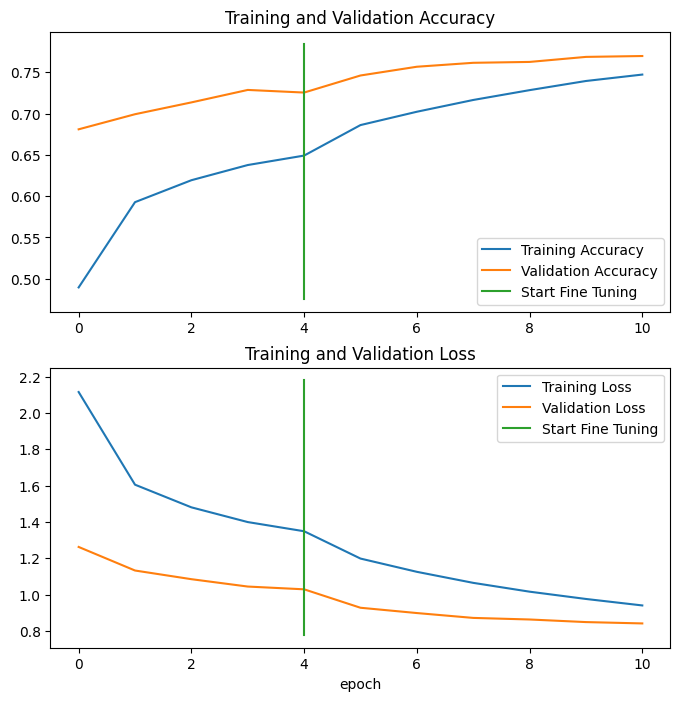

In [ ]:
compare_historys(history,history_fine_tune_model_10_layer)

In [ ]:
model.evaluate(test_data)

790/790 [==============================] - 54s 68ms/step - loss: 0.8528 - accuracy: 0.7656


[0.8528159260749817, 0.7655841708183289]

Good to see we reach the accuracy of 76.56 % , pretty close to our target i.e 77.4 %. But our model doesn't overfits because after some epochs the validation accurcy is not increased to much while training set does. So in net training we will unfreeze all the layers of Efficient net and makes the training accuracy puch further.

In [ ]:
# Load the original model from the local drive:
saved_model = tf.keras.models.load_model('/content/drive/MyDrive/Tensorflow/CNN project/model.keras')

In [ ]:
# Verify the model:
saved_model.evaluate(test_data)

790/790 [==============================] - 55s 66ms/step - loss: 1.0344 - accuracy: 0.7232


[1.0343741178512573, 0.7231683135032654]

## Preparing our model's layers for fine-tuning all Layers

Our feature-extraction model is showing some great promise after three epochs. But since we've got so much data, it's probably worthwhile that we see what results we can get with fine-tuning (fine-tuning usually works best when you've got quite a large amount of data).

Remember our goal of beating the [DeepFood paper](https://arxiv.org/pdf/1606.05675.pdf)?

They were able to achieve 77.4% top-1 accuracy on Food101 over 2-3 days of training.



## A couple more callbacks

We're about to start fine-tuning a deep learning model with over 200 layers using over 100,000 (75k+ training, 25K+ testing) images, which means our model's training time is probably going to be much longer than before.

> 🤔 **Question:** *How long does training take?*

It could be a couple of hours or in the case of the [DeepFood paper](https://arxiv.org/pdf/1606.05675.pdf) (the baseline we're trying to beat), their best performing model took 2-3 days of training time.

You will really only know how long it'll take once you start training.

> 🤔 **Question:** *When do you stop training?*

Ideally, when your model stops improving. But again, due to the nature of deep learning, it can be hard to know when exactly a model will stop improving.

Luckily, there's a solution: the [`EarlyStopping` callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).

The `EarlyStopping` callback monitors a specified model performance metric (e.g. `val_loss`) and when it stops improving for a specified number of epochs, automatically stops training.

Using the `EarlyStopping` callback combined with the `ModelCheckpoint` callback saving the best performing model automatically, we could keep our model training for an unlimited number of epochs until it stops improving.

Let's set both of these up to monitor our model's `val_loss`.

In [ ]:
# Creating a callback for early stoping:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           patience=3)

# Creating a callback for learning rate:
learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                              factor=0.2,
                                                              patience=3,
                                                              verbose=1,
                                                              min_lr = 1e-7)

In [ ]:
# Unfreeze all the layers of the base model:
saved_model.layers[1].trainable=True

In [ ]:
# Compile the model again:
saved_model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
                       metrics=['accuracy'])

In [ ]:
# Check the trainable and Precision Policy:
for layer in saved_model.layers[1].layers:
  print(layer.name,layer.dtype,layer.dtype_policy,layer.trainable)

input_1 float32 <Policy "float32"> True
rescaling float32 <Policy "mixed_float16"> True
normalization float32 <Policy "mixed_float16"> True
stem_conv float32 <Policy "mixed_float16"> True
stem_bn float32 <Policy "mixed_float16"> True
stem_activation float32 <Policy "mixed_float16"> True
block1a_project_conv float32 <Policy "mixed_float16"> True
block1a_project_bn float32 <Policy "mixed_float16"> True
block1a_project_activation float32 <Policy "mixed_float16"> True
block2a_expand_conv float32 <Policy "mixed_float16"> True
block2a_expand_bn float32 <Policy "mixed_float16"> True
block2a_expand_activation float32 <Policy "mixed_float16"> True
block2a_project_conv float32 <Policy "mixed_float16"> True
block2a_project_bn float32 <Policy "mixed_float16"> True
block2b_expand_conv float32 <Policy "mixed_float16"> True
block2b_expand_bn float32 <Policy "mixed_float16"> True
block2b_expand_activation float32 <Policy "mixed_float16"> True
block2b_project_conv float32 <Policy "mixed_float16"> True


In [ ]:
# Execute the whole model:
final_model_history = saved_model.fit(train_data,
                                         epochs=100,
                                         steps_per_epoch=len(train_data),
                                         validation_data=test_data,
                                         validation_steps=int(0.15 * len(test_data)),
                                         callbacks=[create_tensorboard_callback("training_logs", "final_model"),
                                         weight_saving_chekpoint('final_model'),
                                         early_stopping_callback,
                                         learning_rate_callback])

Saving TensorBoard log files to: training_logs/final_model/20231223-135825
Epoch 1/100
2368/2368 [==============================] - 400s 143ms/step - loss: 1.0284 - accuracy: 0.7247 - val_loss: 0.7582 - val_accuracy: 0.7842 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 354s 148ms/step - loss: 0.7429 - accuracy: 0.7953 - val_loss: 0.7130 - val_accuracy: 0.7963 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 346s 145ms/step - loss: 0.5502 - accuracy: 0.8452 - val_loss: 0.7533 - val_accuracy: 0.7966 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 353s 148ms/step - loss: 0.4045 - accuracy: 0.8836 - val_loss: 0.7729 - val_accuracy: 0.7953 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - ETA: 0s - loss: 0.2979 - accuracy: 0.9105
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 345s 145ms/step - loss: 0.2979 - accurac

In [ ]:
saved_model.evaluate(test_data)

790/790 [==============================] - 55s 70ms/step - loss: 0.7985 - accuracy: 0.7998


[0.7984961271286011, 0.7997623682022095]

Congrats we beats the Food 101 paper,s accuracy 77.4% by 79.98% in just 1 hour.

In [ ]:
# Save the model so we again not have to start from scratch:
saved_model.save('/content/drive/MyDrive/Tensorflow/CNN project/final_model.keras')

In [ ]:
# Check if our svaed weight model shows gain on accuracy:
# Load the weights:
saved_model.load_weights("/content/model_checkpoint/final_model.ckpt")
# Evaluate the model:
saved_model.evaluate(test_data)

790/790 [==============================] - 54s 69ms/step - loss: 0.7985 - accuracy: 0.7998


[0.7984961271286011, 0.7997623682022095]

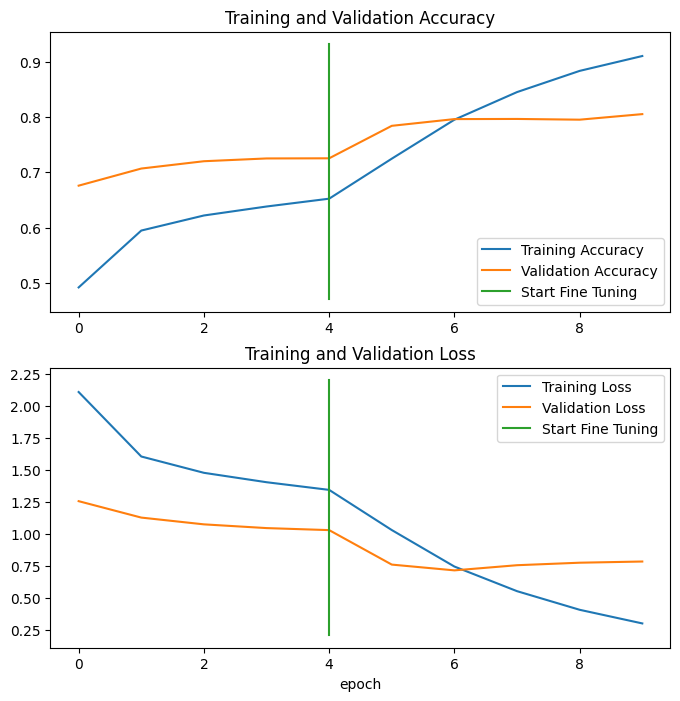

In [ ]:
compare_historys(history,final_model_history)

In [ ]:
saved_model.save('/content/drive/MyDrive/Tensorflow/CNN project/final_model_best_weight.keras')

In [32]:
# Load the best weights model for further process:
model = tf.keras.models.load_model('/content/drive/MyDrive/Tensorflow/CNN project/final_model_best_weight.keras')

In [33]:
# Again calculate the accuracy and loss:
model.evaluate(test_data)

790/790 [==============================] - 60s 63ms/step - loss: 0.7985 - accuracy: 0.7999


[0.7984971404075623, 0.7998811602592468]

In [34]:
# Now its time to make prediction on the test data:
pred_probs = model.predict(test_data)

790/790 [==============================] - 52s 63ms/step


In [35]:
# How many are there ?
pred_probs.shape

(25250, 101)

In [36]:
# As we know the output from the predictions are one hot encoded:
import numpy as np
pred_class = np.argmax(pred_probs,axis=1)
pred_class[:10]

array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100])

In [37]:
# No of batches of our test data:
len(test_data)

790

In [38]:
# Now its time to unravel 790 batches of test data and make a list of actual values:
actual_class = []
for image, label in test_data.unbatch():
  actual_class.append(label.numpy())

actual_class[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [39]:
# verifying the accuracy from sklearn:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(actual_class, pred_class)
sklearn_accuracy

0.7998811881188119

Got the Same value.

**NOTE:** We have put shuffle = False in the begining while we load the dataset because it will shuffle the data each time when we call for data and can't verify accuracy from Sklearn and further investigation too.

## Evaluating our models predictions

In [40]:
# creating a function to create a confusion matrix:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

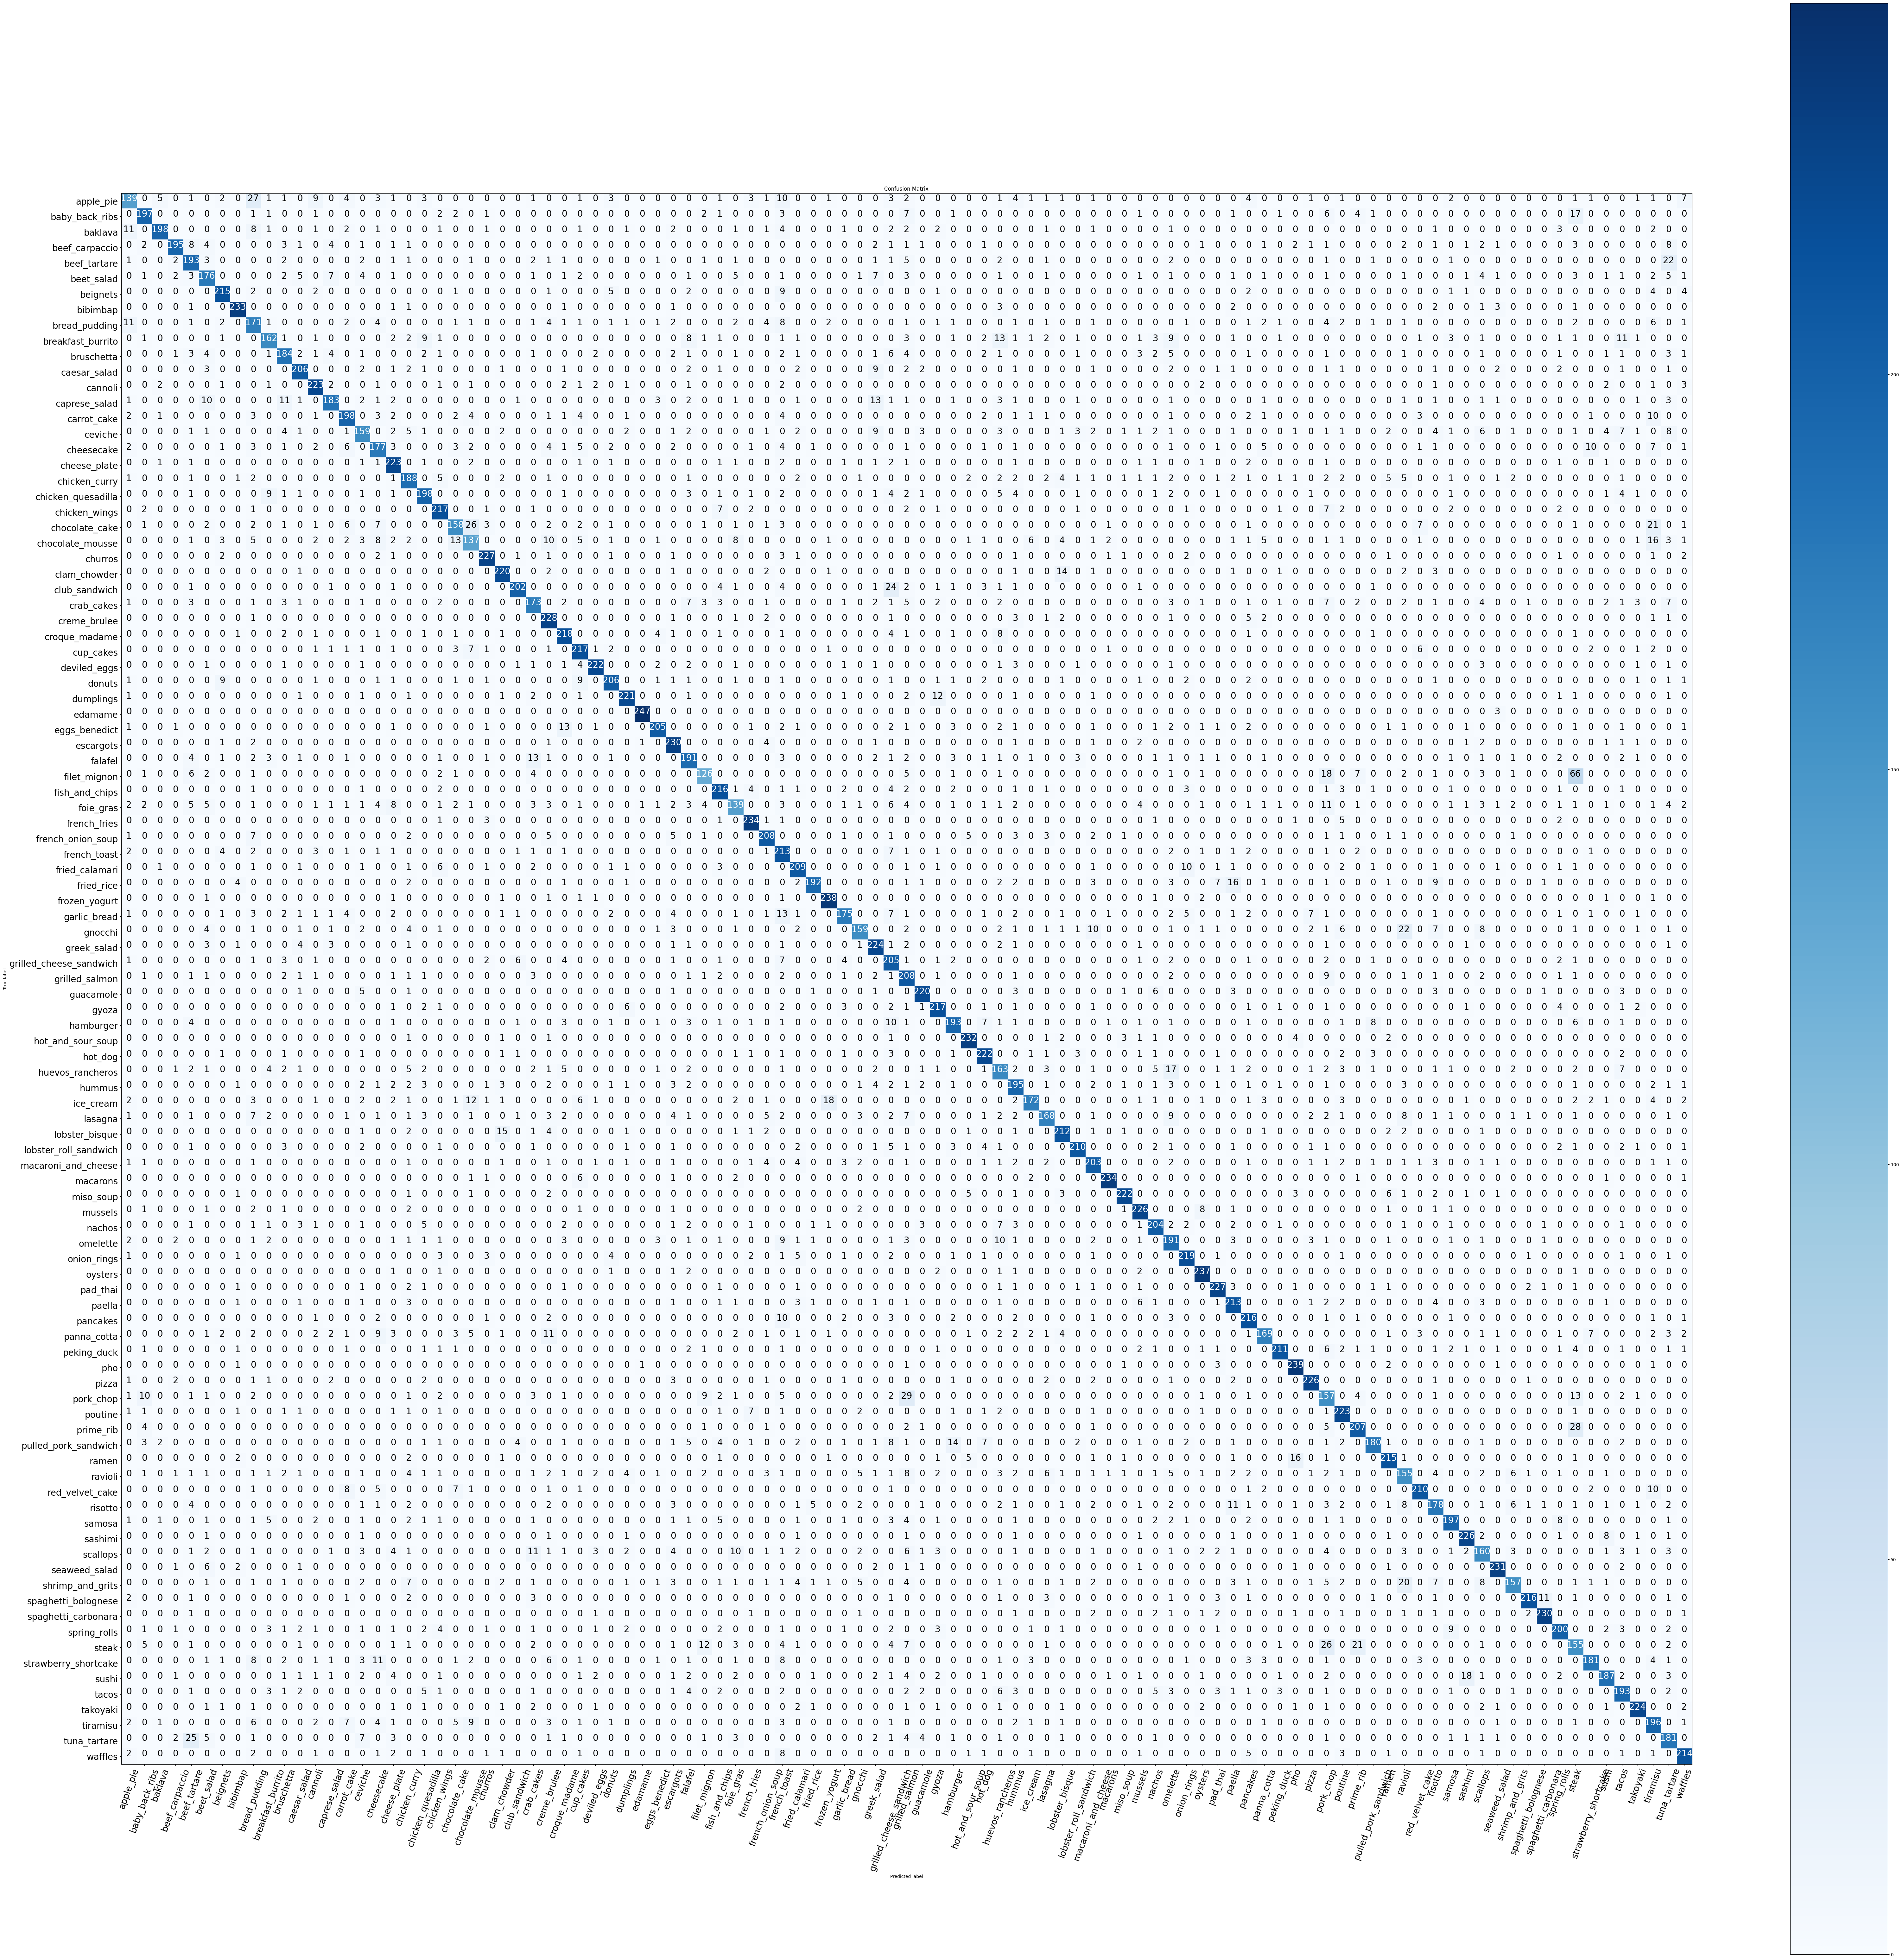

In [41]:
# Plotting the confusion matrix:
make_confusion_matrix(y_true = actual_class,
                      y_pred = pred_class,
                      classes=class_names,
                      figsize=(80,80),
                      text_size=20)

Confusion matrix looks good. But with some dishes our model gets confused.

eg. Model give 66 wrong prediction on fillet mignon and steak. Lets check the image. [Fillet Mignon](https://www.google.com/search?q=filet+mignon+dish&sca_esv=593593980&hl=en&tbm=isch&sxsrf=AM9HkKkuAzjOC7CURZTsgwi0KH5eDtIwOQ:1703513910353&source=lnms&sa=X&ved=2ahUKEwjw_vvr46qDAxX7TmwGHdiABSEQ_AUoAnoECAEQBA&biw=2400&bih=1206&dpr=0.8) & [Steak](https://www.google.com/search?q=steak+dish&tbm=isch&ved=2ahUKEwi9tvns46qDAxXQSmwGHX0sCvsQ2-cCegQIABAA&oq=steak+dish&gs_lcp=CgNpbWcQAzIECCMQJzIFCAAQgAQyBQgAEIAEMgUIABCABDIFCAAQgAQyBQgAEIAEMgUIABCABDIFCAAQgAQyBQgAEIAEMgUIABCABDoGCAAQBRAeOgYIABAIEB46BwgAEIAEEBg6BggAEAcQHjoNCAAQgAQQigUQQxCxAzoICAAQgAQQsQM6CggAEIAEEIoFEENQ1AVYuCRg8SZoAHAAeACAAbwCiAGQFpIBCDAuMTYuMS4xmAEAoAEBqgELZ3dzLXdpei1pbWfAAQE&sclient=img&ei=OI-JZb26GNCVseMP_dio2A8&bih=1206&biw=2400&hl=en) boths are look exactly same.

In [42]:
# Classification report:
from sklearn.metrics import classification_report
print(classification_report(y_true = actual_class,
                      y_pred=pred_class))

              precision    recall  f1-score   support

           0       0.71      0.56      0.62       250
           1       0.83      0.79      0.81       250
           2       0.93      0.79      0.86       250
           3       0.92      0.78      0.84       250
           4       0.69      0.77      0.73       250
           5       0.72      0.70      0.71       250
           6       0.87      0.86      0.86       250
           7       0.92      0.93      0.93       250
           8       0.59      0.68      0.63       250
           9       0.80      0.65      0.72       250
          10       0.77      0.74      0.75       250
          11       0.84      0.82      0.83       250
          12       0.84      0.89      0.86       250
          13       0.85      0.73      0.79       250
          14       0.80      0.79      0.80       250
          15       0.71      0.64      0.67       250
          16       0.71      0.71      0.71       250
          17       0.77    

In [43]:
# Get the classification report to the dict:
classification_report_dict = classification_report(y_true = actual_class,
                                                  y_pred=pred_class,
                                                   output_dict=True)
classification_report_dict

{'0': {'precision': 0.7091836734693877,
  'recall': 0.556,
  'f1-score': 0.6233183856502242,
  'support': 250},
 '1': {'precision': 0.8347457627118644,
  'recall': 0.788,
  'f1-score': 0.8106995884773662,
  'support': 250},
 '2': {'precision': 0.9339622641509434,
  'recall': 0.792,
  'f1-score': 0.8571428571428572,
  'support': 250},
 '3': {'precision': 0.9198113207547169,
  'recall': 0.78,
  'f1-score': 0.8441558441558441,
  'support': 250},
 '4': {'precision': 0.6892857142857143,
  'recall': 0.772,
  'f1-score': 0.7283018867924528,
  'support': 250},
 '5': {'precision': 0.7242798353909465,
  'recall': 0.704,
  'f1-score': 0.7139959432048681,
  'support': 250},
 '6': {'precision': 0.8669354838709677,
  'recall': 0.86,
  'f1-score': 0.8634538152610441,
  'support': 250},
 '7': {'precision': 0.9246031746031746,
  'recall': 0.932,
  'f1-score': 0.9282868525896414,
  'support': 250},
 '8': {'precision': 0.5856164383561644,
  'recall': 0.684,
  'f1-score': 0.6309963099630997,
  'support': 

In [44]:
# Create a dictionary of Food classes and its F1-score:
f1_score_dict = {}
for i,j in classification_report_dict.items():
  if i=='accuracy':
    break
  else:
    f1_score_dict[class_names[int(i)]] = round(j['f1-score'],3)

print(f1_score_dict)

{'apple_pie': 0.623, 'baby_back_ribs': 0.811, 'baklava': 0.857, 'beef_carpaccio': 0.844, 'beef_tartare': 0.728, 'beet_salad': 0.714, 'beignets': 0.863, 'bibimbap': 0.928, 'bread_pudding': 0.631, 'breakfast_burrito': 0.717, 'bruschetta': 0.751, 'caesar_salad': 0.834, 'cannoli': 0.863, 'caprese_salad': 0.787, 'carrot_cake': 0.795, 'ceviche': 0.672, 'cheesecake': 0.708, 'cheese_plate': 0.824, 'chicken_curry': 0.737, 'chicken_quesadilla': 0.794, 'chicken_wings': 0.844, 'chocolate_cake': 0.693, 'chocolate_mousse': 0.591, 'churros': 0.904, 'clam_chowder': 0.868, 'club_sandwich': 0.86, 'crab_cakes': 0.708, 'creme_brulee': 0.813, 'croque_madame': 0.837, 'cup_cakes': 0.828, 'deviled_eggs': 0.904, 'donuts': 0.849, 'dumplings': 0.886, 'edamame': 0.988, 'eggs_benedict': 0.858, 'escargots': 0.846, 'falafel': 0.752, 'filet_mignon': 0.606, 'fish_and_chips': 0.837, 'foie_gras': 0.622, 'french_fries': 0.914, 'french_onion_soup': 0.835, 'french_toast': 0.683, 'fried_calamari': 0.824, 'fried_rice': 0.844

In [45]:
# Creating the DataFrame and Visualize it :
import pandas as pd
import seaborn as sns
f1_score_df = pd.DataFrame({"class_names":f1_score_dict.keys(),'F1_score':f1_score_dict.values()}).sort_values(by='F1_score',ascending=False,ignore_index=True)

In [46]:
f1_score_df.head(10)

class_names  F1_score
0              edamame     0.988
1             macarons     0.949
2             bibimbap     0.928
3  spaghetti_carbonara     0.926
4        frozen_yogurt     0.922
5    hot_and_sour_soup     0.922
6        seaweed_salad     0.918
7                  pho     0.914
8         french_fries     0.914
9            miso_soup     0.914

<Axes: xlabel='F1_score', ylabel='class_names'>

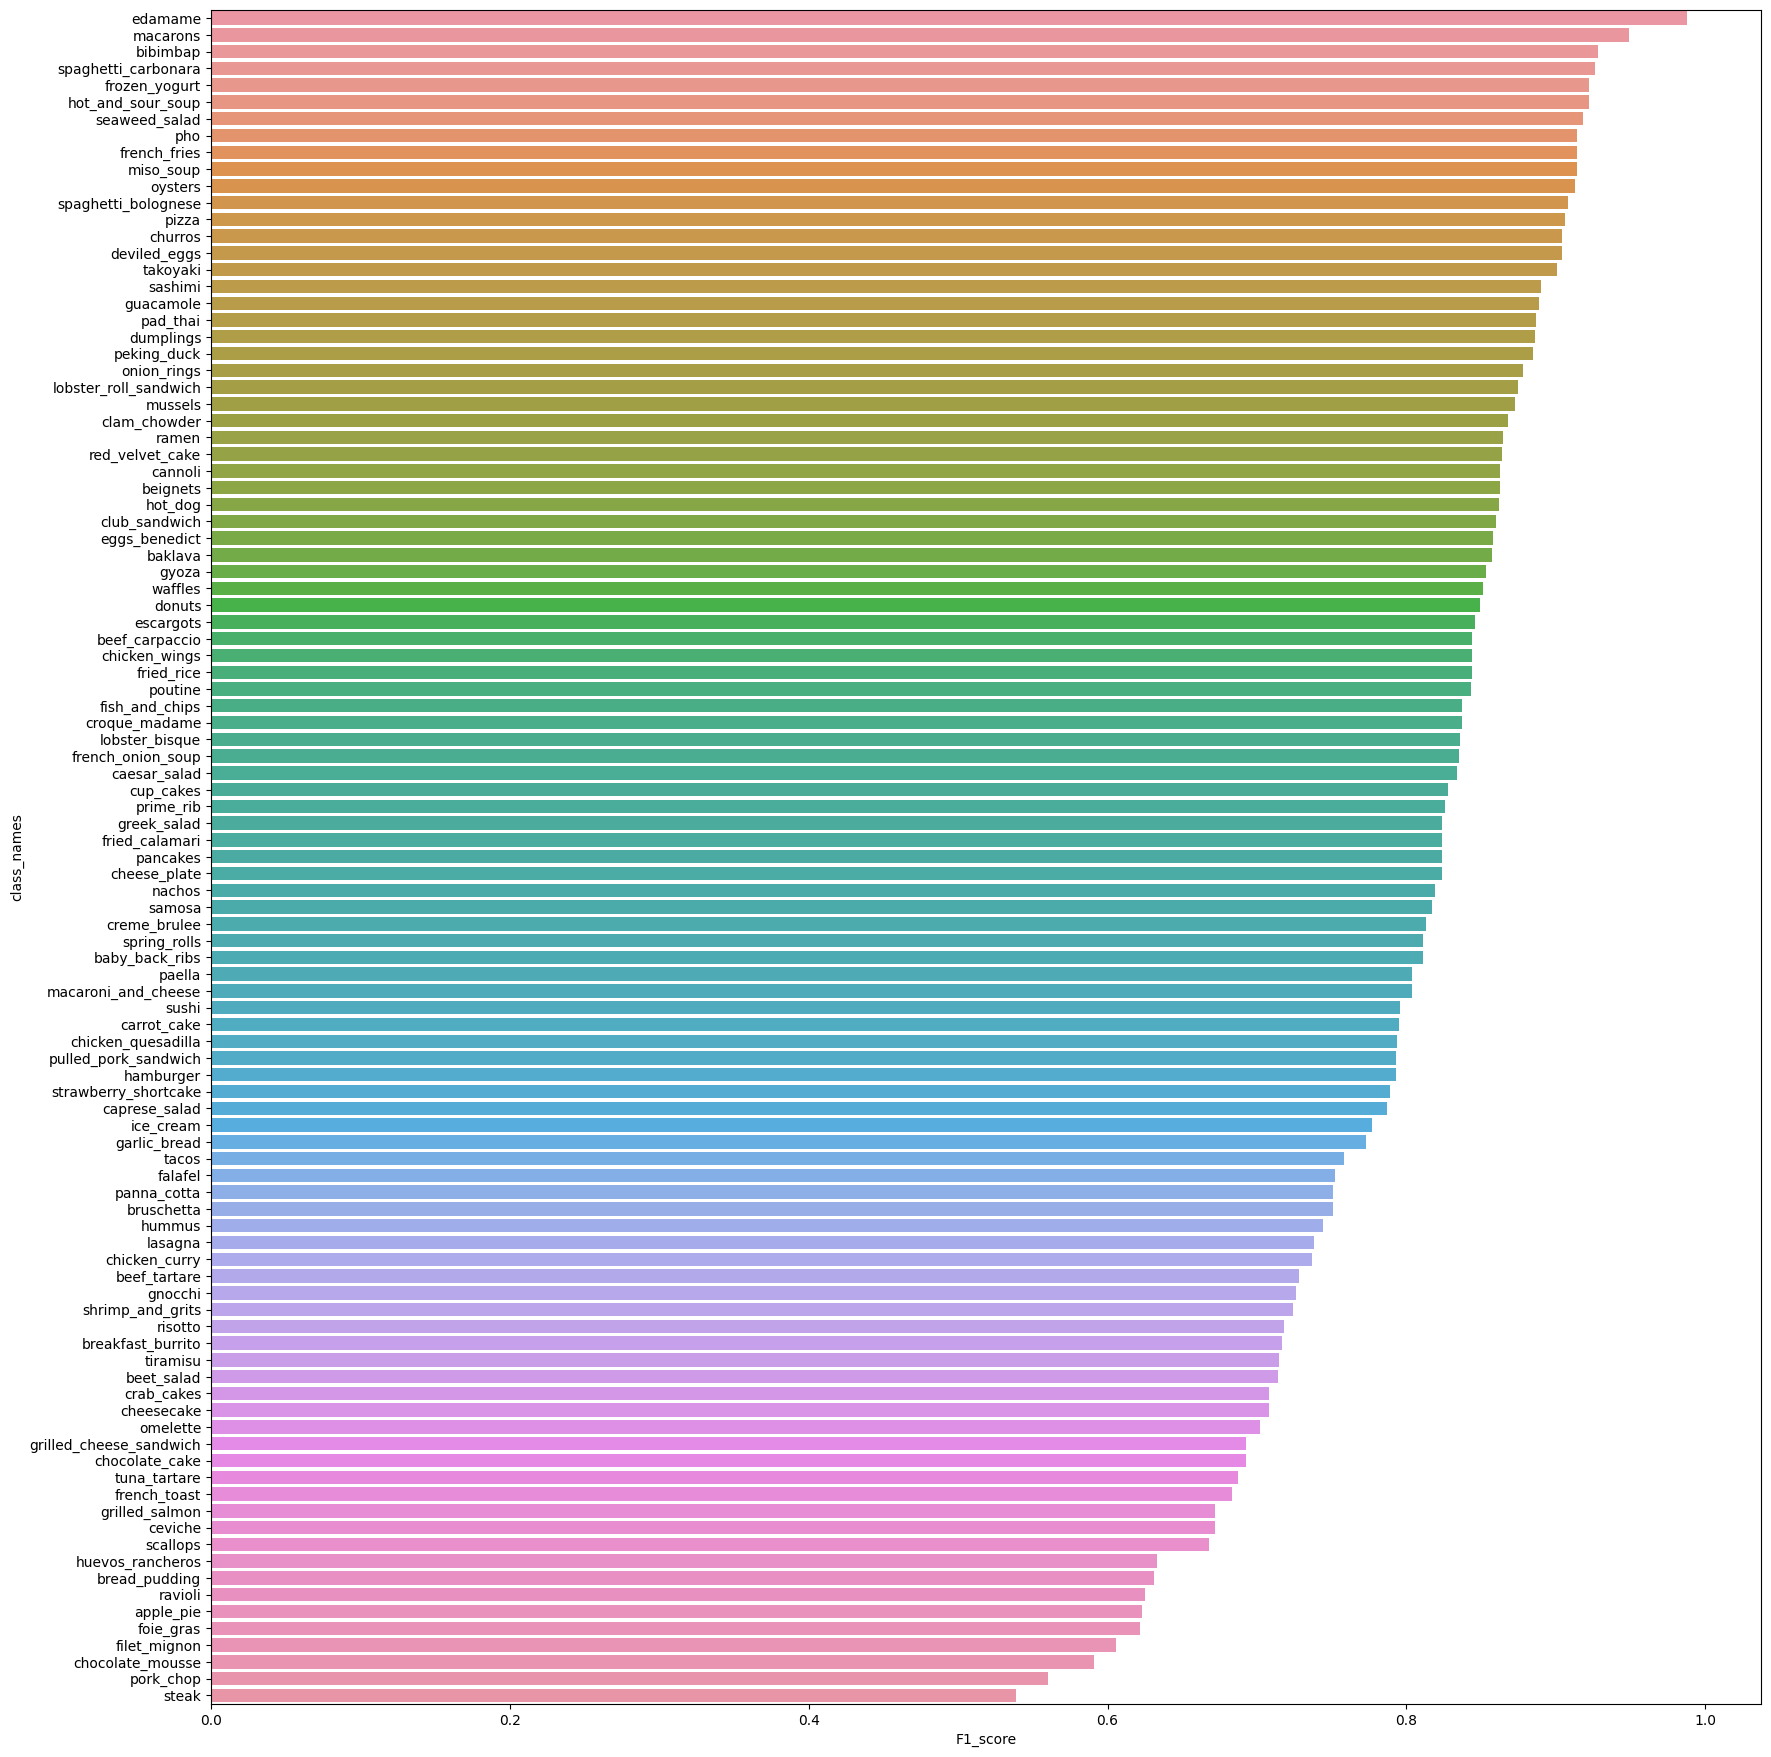

In [47]:
plt.figure(figsize=(20,22))
sns.barplot(f1_score_df, y="class_names", x="F1_score")

## Visualize from the Dataset:

In [48]:
# Unbatch the Dataset Again:
test_data = test_data.unbatch()

1/1 [==============================] - 0s 26ms/step


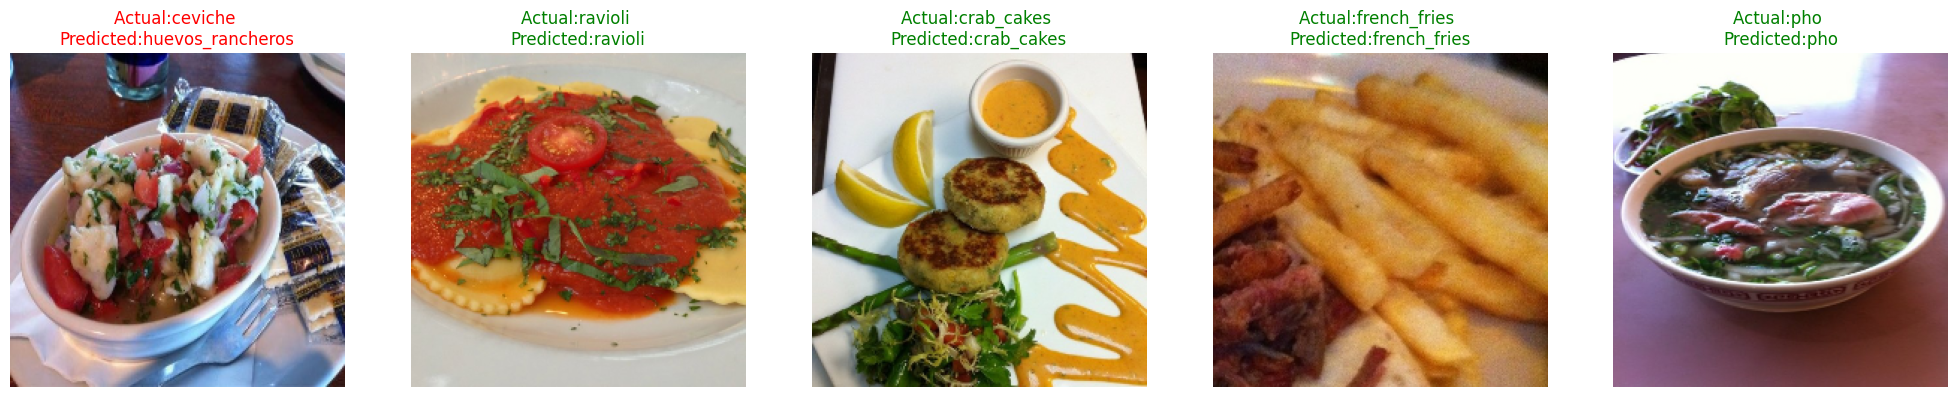

In [49]:
# Now we are going to make prediction on the Test dataset itself:
import random

plt.figure(figsize=(25, 20))

for i in range(5):
    index_to_select = random.randint(0, 25249)
    skipped_data = test_data.skip(index_to_select)
    selected_image = skipped_data.take(1)

    for img, actual_label in selected_image:
        img = tf.image.resize(img, [224, 224])
        model_prediction = np.argmax(model.predict(tf.expand_dims(img, axis=0)))
        plt.subplot(1, 5, i+1)
        plt.imshow(img/255.)
        if actual_label.numpy() == model_prediction:
          color = 'g'
        else:
          color = 'r'
        plt.title(f"Actual:{class_names[actual_label.numpy()]} \nPredicted:{class_names[model_prediction]}",c=color)
        plt.axis(False)

##Finding the most wrong predictions
It's a good idea to go through at least 100+ random instances of your model's predictions to get a good feel for how it's doing.

After a while you might notice the model predicting on some images with a very high prediction probability, meaning it's very confident with its prediction but still getting the label wrong.

These most wrong predictions can help to give further insight into your model's performance.

So how about we write some code to collect all of the predictions where the model has output a high prediction probability for an image (e.g. 0.95+) but gotten the prediction wrong.

We'll go through the following steps:

1. Create a pandas DataFrame of the image index_label, actual_class, prediction classes, max prediction probabilities.
**Note**: We don't necessarily have to create a DataFrame like this but it'll help us visualize things as we go.
2. Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).
3. Sort the DataFrame based on wrong predictions and highest max prediction probabilities.
4. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [51]:
# Create a dataframe which have index label, Actual class, Prediction class, and probabilty:
df = pd.DataFrame({"index_label":list(range(len(pred_class))),
                   "Actual_class":[class_names[i] for i in actual_class],
                   "Prediction":[class_names[i] for i in pred_class],
                   "Probability":np.max(pred_probs,axis=-1)})
df.head(10)

index_label         Actual_class           Prediction  Probability
0            0            cup_cakes            cup_cakes     0.994438
1            1                ramen                ramen     0.999654
2            2  spaghetti_carbonara  spaghetti_carbonara     0.998300
3            3            hamburger            hamburger     0.991974
4            4             takoyaki             takoyaki     0.999990
5            5             takoyaki             takoyaki     0.967360
6            6           bruschetta           bruschetta     0.973317
7            7               donuts               donuts     1.000000
8            8       beef_carpaccio       beef_carpaccio     0.999950
9            9              waffles              waffles     0.897408

In [52]:
# Creating a new column to check wheather prediction is True or False:
df["pred_correct"] = df['Actual_class'] == df['Prediction']

In [54]:
# Take top 100 wrong prediction with high probability:
top_100_wrong = df[df["pred_correct"] == False].sort_values("Probability", ascending=False)[:100]
top_100_wrong.head(20)

index_label    Actual_class       Prediction  Probability  pred_correct
3182          3182  chocolate_cake  red_velvet_cake     0.999987         False
17440        17440         churros      onion_rings     0.999980         False
217            217      fried_rice           paella     0.999967         False
11626        11626          donuts         beignets     0.999964         False
13884        13884    garlic_bread       bruschetta     0.999960         False
1113          1113        pancakes         omelette     0.999941         False
24344        24344  fried_calamari    chicken_curry     0.999817         False
14471        14471      cheesecake     cheese_plate     0.999815         False
21346        21346             pho         tiramisu     0.999773         False
1717          1717        pancakes     french_toast     0.999724         False
13025        13025      bruschetta    caprese_salad     0.999644         False
13004        13004        pancakes     french_toast     0.999614         False
3735          3735           sushi          hot_dog     0.999579         False
9219          9219           sushi          sashimi     0.999529         False
12138        12138       ice_cream          poutine     0.999418         False
16129        16129         mussels          oysters     0.999416         False
22364        22364    filet_mignon     beef_tartare     0.999380         False
14504        14504       dumplings            gyoza     0.999354         False
23006        23006       guacamole          risotto     0.999343         False
4250          4250    clam_chowder          risotto     0.999315         False

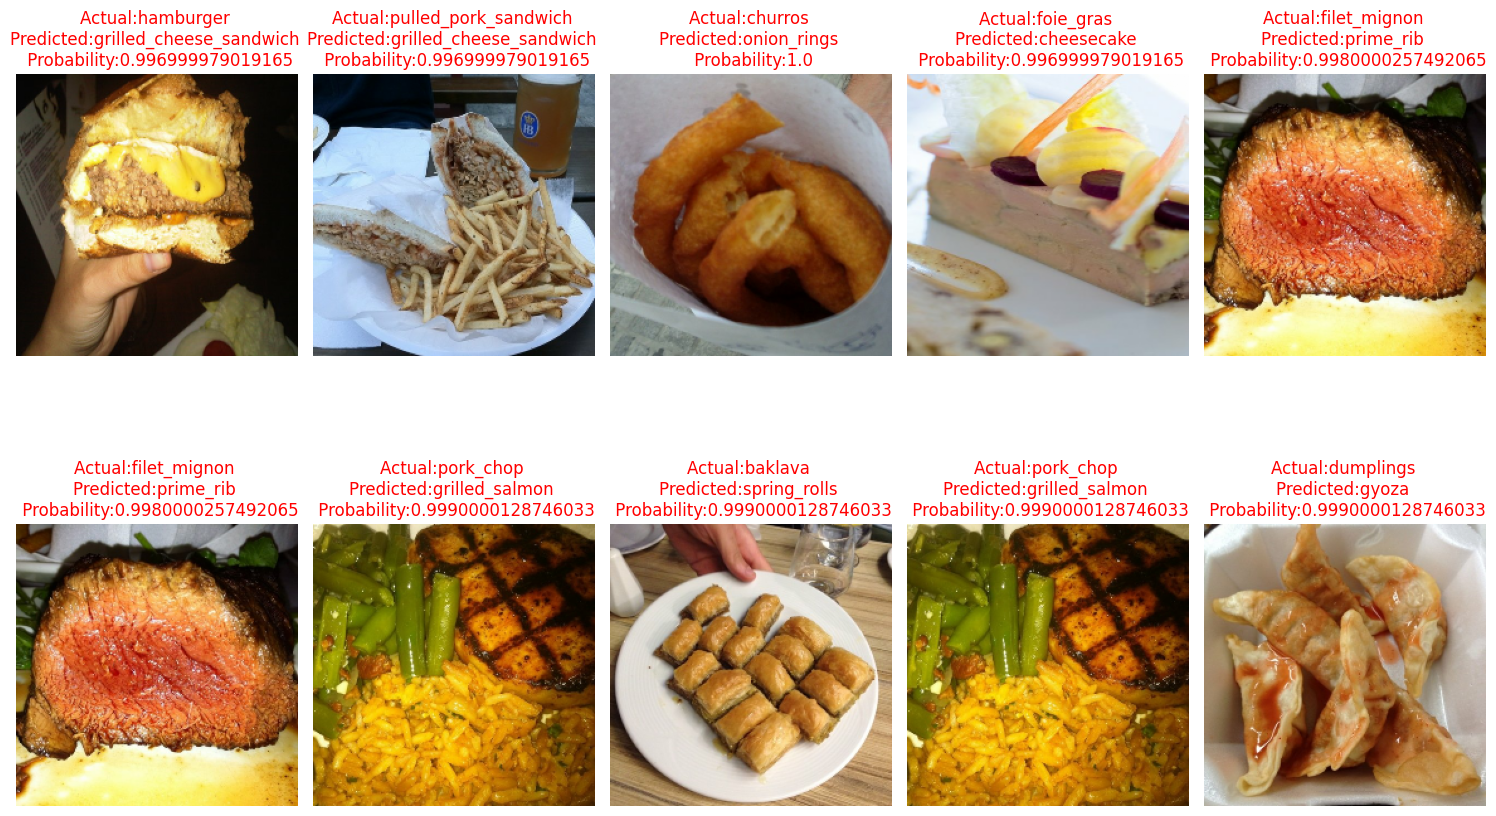

In [55]:
plt.figure(figsize=(15,10))

for i in range(10):
  image_index = random.choice(list(top_100_wrong['index_label']))
  selected_data = test_data.skip(image_index).take(1)

  for image, label in selected_data:
    img = tf.image.resize(image, [224, 224])
    plt.subplot(2, 5, i+1)
    plt.imshow(img / 255.)
    plt.title(f"Actual:{class_names[label.numpy()]} \nPredicted:{top_100_wrong.loc[top_100_wrong['index_label'] == image_index, 'Prediction'].values[0]} \n Probability:{round(top_100_wrong.loc[top_100_wrong['index_label'] == image_index, 'Probability'].values[0],3)}",color='r')
    plt.axis(False)

plt.tight_layout()


Going through the model's most wrong predictions can usually help figure out a couple of things:

* **Some of the labels might be wrong**- If our model ends up being good enough, it may actually learning to predict very well on certain classes. This means some images which the model predicts the right label may show up as wrong if the ground truth label is wrong. If this is the case, we can often use our model to help us improve the labels in our dataset(s) and in turn, potentially making future models better. This process of using the model to help improve.

* **labels is often referred to as active learning.**
Could more samples be collected? - If there's a recurring pattern for a certain class being poorly predicted on, perhaps it's a good idea to collect more samples of that particular class in different scenarios to improve further models.

# Finished